In [11]:
%%capture
# ! pip install networkx # good notebook
# ! pip install matplotlib
# ! pip install pyvis

In [12]:
%%capture
# part 1: parse step input file
import json
import networkx as nx
step_file_dict = json.load(open("data.json"))

# loading new graph input:
# Open the file and read its contents
with open('input.json', 'r') as f:
    data = f.read()

# Use the json.loads() function to decode the JSON data
my_data = json.loads(data)
G = nx.node_link_graph(my_data, directed=True)
pos = nx.spring_layout(G) # keep position of nodes
print(G.edges)

# create a dict of the arrays
graph_structure = json.load(open("input.json"))
links = graph_structure["links"]




simulation_steps = step_file_dict["steps"]
amount_of_devices = step_file_dict["devices"]
amount_of_wires = step_file_dict["wires"]

for step_index in range(simulation_steps):
  print("\nstep: " + str(step_index))
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    print("device-" + str(device_index) + " state: " + device_state)

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]["STATE"]
    wire_data = step["w-" + str(wire_index)]["DATA"]
    print("wire-" + str(wire_index) + " state: " + wire_state + " data: " + wire_data)

In [13]:
%%capture
# generate analysis of network flow
from matplotlib import pyplot as plt, animation

def network_flow_stats():
  # generate a graph of traffic of flow through wires

  # initialize each wire's traffic to 0
  wire_traffic = {}
  for i in range(amount_of_wires):
    wire_traffic[i] = 0

  # increase each wire's traffic for each timestep it's in-use
  for step_index in range(simulation_steps):
    step = step_file_dict["step-" + str(step_index)]

    for wire_index in range(amount_of_wires):
      wire_state = step["w-" + str(wire_index)]["STATE"]
      if(wire_state == "IN_USE"):
          wire_traffic[wire_index] = wire_traffic[wire_index] + 1

  # generate bar graph of network traffic of each wire
  fig = plt.figure(figsize = (10, 5))

  plt.bar(wire_traffic.keys(), wire_traffic.values(), color ='green',
        width = 0.4)
  plt.show()

network_flow_stats()


In [14]:
%%capture
# generate analysis of network flow
from matplotlib import pyplot as plt, animation

def node_traffic_stats():
  # generate a graph of node (non-idle) traffic from perspective of devices

  # initialize each devices's traffic to 0
  device_traffic = {}
  for i in range(amount_of_devices):
    device_traffic[i] = 0

  # increase each wire's traffic for each timestep it's in-use
  for step_index in range(simulation_steps):
    step = step_file_dict["step-" + str(step_index)]

    for device_index in range(amount_of_devices):
      device_state = step["d-" + str(device_index)]
      if(device_state != "IDLE"):
          device_traffic[device_index] = device_traffic[device_index] + 1

  # generate bar graph of network traffic of each device
  fig = plt.figure(figsize = (10, 5))

  plt.bar(device_traffic.keys(), device_traffic.values(), color ='orange',
        width = 0.4)
  plt.show()

node_traffic_stats()

In [15]:
from pyvis.network import Network
from IPython.core.display import display, HTML

K = nx.path_graph(20)
# K = nx.grid_2d_graph(4, 4)

# display graph
nt = Network(notebook=True, width="100%", height="800px", cdn_resources='in_line')
nt.from_nx(K) 
nt.show('nt.html')
display(HTML('nt.html'))

nt.html


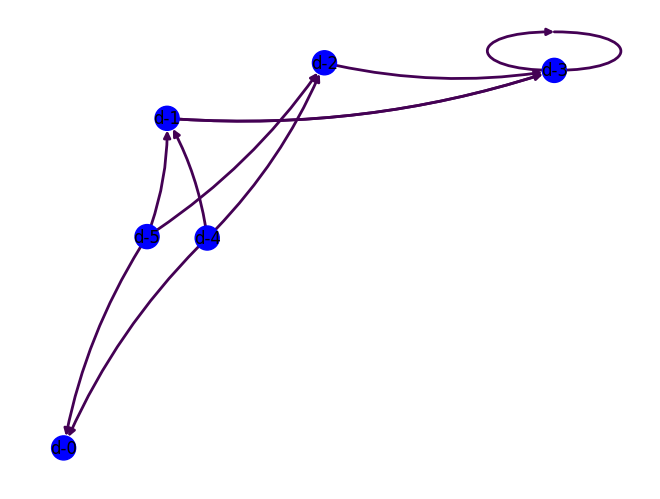

In [19]:
# %matplotlib inline
from matplotlib import pyplot as plt, animation
from matplotlib import rc
from IPython.core.display import display, HTML
import random


# set up animation figure
rc('animation', html='jshtml')
fig = plt.figure()






def animate(frame):
  # animate a frame based on the state
  fig.clear()
  
  device_color_map = []
  edge_color_map = []
  wire_color_dict = G.edges()

  # get the step for this frame
  step_index = frame
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    if(device_state == "IDLE"):
      device_color_map.append("blue")
    elif(device_state == "SENDING"):
      device_color_map.append("pink")
    else:
      device_color_map.append("lightgreen")

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]["STATE"]
    wire_data = step["w-" + str(wire_index)]["DATA"]
    if(wire_state == "EMPTY"):
      G[links[wire_index]["source"]][links[wire_index]["target"]][0]['weight'] = 2.0
    else:
      G[links[wire_index]["source"]][links[wire_index]["target"]][0]['weight'] = 6.0
      # print("w-" + str(wire_index) + " has data of " + wire_data)

  # get weights for wires
  edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

  # temporary fix for mismatch in dimensions for edge_color_map and edge_color argument
  device_color_map.append("blue")
  edge_color_map = list(weights)
  edge_color_map.append(2)


  nx.draw(G, pos=pos, node_color=device_color_map, connectionstyle='arc3, rad = 0.1', width=weights, edge_color=edge_color_map, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=simulation_steps, interval=1000, repeat=True)
ani